# FCN

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchmetrics

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/Users/louis/anaconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## Dataset

In [3]:
data_dir = '../dataset/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
unlabel_dir = data_dir + 'unlabeled/'

In [4]:
class MaskDataset(Dataset):
    def __init__(self, root='../dataset/train/', transform=None):
        self.root = root
        self.transform = transform
        self.vid_list = sorted(os.listdir(root))
        self.img_list = ['image_' + str(i) + '.png' for i in range(22)]
    
    def __len__(self):
        return len(self.vid_list) * 22

    def __getitem__(self, idx):
        vid_idx = idx // 22
        img_idx = idx % 22
        # load image
        img_path = os.path.join(self.root, self.vid_list[vid_idx], self.img_list[img_idx])
        img = Image.open(img_path).convert("RGB")
        # load mask
        mask_path = os.path.join(self.root, self.vid_list[vid_idx], 'mask.npy')
        target = np.load(mask_path)[img_idx]
        # transforms
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset_train = MaskDataset(transform=transform)

In [6]:
len(dataset_train)

22000

In [7]:
dataloader = DataLoader(
    dataset_train,
    batch_size=8,
    shuffle=True,
)

img, target = next(iter(dataloader))
print(img.shape, target.shape)

torch.Size([8, 3, 160, 240]) torch.Size([8, 160, 240])


## Data Augmentation

In [ ]:
import torchvision.transforms as T

brightness = 0.4
contrast = 0.4
saturation = 0.4

transform = T.Compose([
    T.RandomResizedCrop(size=(160, 240), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
    ),
    T.RandomAdjustSharpness(sharpness_factor=5), 
    T.GaussianBlur(kernel_size=(3, 9), sigma=(0.1, 2)),
    T.RandomGrayscale(p=0.1),
    # T.PILToTensor(),
    # T.ConvertImageDtype(torch.float),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset_train = MaskDataset(transform=transform)
dataset_train[0][0]

In [ ]:
dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)
img, target = next(iter(dataloader))

## Train

In [ ]:
lr = 1e-2
batch_size = 8

In [ ]:
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [ ]:
model = models.segmentation.fcn_resnet50(
    weights=None,
    weights_backbone=models.ResNet50_Weights.IMAGENET1K_V2, 
    num_classes=49,
    aux_loss=True
).to(device)
model

In [ ]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

In [ ]:
params_to_optimize = [
    {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
    {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
]

params = [p for p in model.aux_classifier.parameters() if p.requires_grad]
params_to_optimize.append({"params": params, "lr": lr * 10})

optimizer = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

In [ ]:
for epoch in range(1):
    print(epoch)
    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)
        
        output = model(imgs)
        loss = criterion(output, targets.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(loss.item())


## Evaluation

In [286]:
imgs, targets = next(iter(dataloader))
# imgs, targets = img.to(device), targets.to(device)

outputs = model(imgs.to(device))

In [287]:
imgs.size(0)

8

In [288]:
output = outputs['out']
output.shape

torch.Size([8, 49, 160, 240])

In [289]:
output = output.cpu().detach().numpy()
output_predictions = output.argmax(1)
output_predictions.shape
bg = torch.zeros_like(targets)

In [290]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49
                                    , average='micro'
                                    )

output_predictions = bg
print(jaccard(torch.Tensor(output_predictions), targets).item())

s = 0.0
for i in range(8):
    j = jaccard(torch.Tensor(output_predictions[i]), targets[i]).item()
    s += j

s / 8

0.9061033129692078


0.9068337678909302

In [ ]:
plt.imshow(imgs[0].permute(1,2,0))

In [ ]:
plt.imshow(output_predictions[0])
output_predictions[0]

In [ ]:
plt.imshow(targets[0])

## Inference

In [64]:
model_path = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/segmentation/output/20230427-111232/fcn_resnet50_best.pth'

model = models.segmentation.fcn_resnet50(num_classes=49, aux_loss=True)

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model = model.to(device)

In [79]:
imgs, targets = next(iter(dataloader))
imgs = imgs.to(device)

outputs = model(imgs)
outs = outputs['out'].cpu().detach().numpy()
out_pred = outs.argmax(1)
out_pred.shape

(8, 160, 240)

array([ 0,  1,  5, 21, 25, 28, 31, 33, 37, 41])

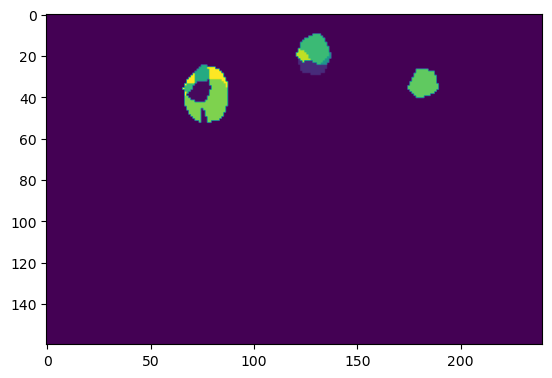

In [80]:
plt.imshow(out_pred[0])
out_pred.max()
np.unique(out_pred[0])

array([ 0, 14, 31, 33, 44], dtype=uint8)

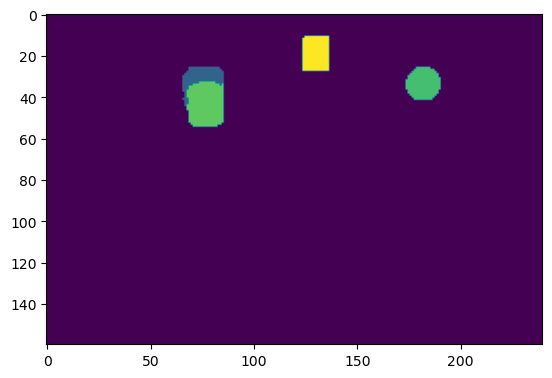

In [81]:
plt.imshow(targets[0].cpu())
np.unique(targets[0])

In [300]:
torch.equal(torch.Tensor(out_pred), targets[0])

False

In [114]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49, 
                                    # average='micro'
                                    )

In [147]:
dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
imgs, targets = next(iter(dataloader))

outputs = model(imgs.to(device))
outs = outputs['out'].cpu().detach().numpy()
out_pred = outs.argmax(1)
out_pred.shape

bg = torch.zeros((32, 160, 240))

print(jaccard(targets, torch.Tensor(out_pred)).item())
print(jaccard(targets, targets).item() )
print(jaccard(targets, bg).item() )

0.21919746696949005
0.9591836333274841
0.019382938742637634


In [88]:
jaccard(targets, bg).item() 

0.01931733638048172

In [235]:
7 / 49

0.14285714285714285

In [ ]:
mask_path = os.path.join(train_dir, 'video_0', 'mask.npy')
mask = np.load(mask_path)[0]

In [ ]:
from torchvision.transforms import functional as F

size = 300

img = F.resize(img, size)

img

In [ ]:
target = torch.Tensor(mask).unsqueeze(0)
print(target.shape)

target = F.resize(target, 250, interpolation=transforms.InterpolationMode.NEAREST)
target.shape

In [ ]:
img_path = os.path.join(train_dir, 'video_0', 'image_0.png')
img = Image.open(img_path).convert('RGB')
img

In [ ]:
from torch import nn
from torchvision import models
import copy
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad
        

class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(2048, 4096, 256)
        self.prediction_head = BYOLPredictionHead(256, 4096, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

In [ ]:
resnet50 = models.resnet50()
model = BYOL(nn.Sequential(*list(resnet50.children())[:-1]))

path = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/ssl/output/backbone-resnet50-0.9041/byol_best.pth'
model.load_state_dict(torch.load(path, map_location='cpu'))

In [ ]:
resnet = models.resnet50()
backbone = nn.Sequential(*list(resnet50.children())[:-1])
backbone.load_state_dict(
    torch.load('/Users/louis/Files/deep-learning/Deep-Learning-VQA/ssl/output/backbone-resnet50-0.9041/resnet50_best.pth', map_location='cpu'), 
    strict=True
)

In [ ]:
model = models.segmentation.fcn_resnet50(
    num_classes=49, 
    aux_loss=True
)

In [ ]:
state_dict = torch.load('/Users/louis/Files/deep-learning/Deep-Learning-VQA/ssl/output/backbone-resnet50-0.9041/resnet50_best.pth', map_location='cpu')

In [186]:
backbone_dir = '/Users/louis/Files/deep-learning/Deep-Learning-VQA/ssl/output/backbone-resnet50-0.9041/resnet50_best.pth'

resnet = models.resnet50()
backbone = nn.Sequential(*list(resnet.children())[:-2])
backbone.load_state_dict(
    torch.load(backbone_dir, map_location='cpu'), 
    strict=True
)

<All keys matched successfully>

In [ ]:
backbone.load_state_dict(state_dict)

In [ ]:
from collections import OrderedDict


model_backbone_keys = list(model.backbone.state_dict().keys())
backbone_keys = list(state_dict.keys())

key_dict = {backbone_keys[i]: model_backbone_keys[i] for i in range(len(backbone_keys))}

adapted_dict = {key_dict[k] : v for k, v in state_dict.items()}

adapted_dict = OrderedDict(adapted_dict)

In [ ]:
model.backbone.load_state_dict(adapted_dict)

In [ ]:
model.backbone.state_dict()

In [ ]:
resnet50 = models.resnet50()
backbone = nn.Sequential(*list(resnet50.children())[:-2])

In [ ]:
X = torch.zeros((1, 3, 160, 240))
y = backbone(X)
y.shape

In [ ]:
180 * 30 / 60**2

In [184]:
fcn_resnet = models.segmentation.fcn_resnet50(num_classes=49, aux_loss=True)

x = torch.zeros((1, 3, 160, 240))
fcn_resnet(x)['out'].shape

torch.Size([1, 49, 160, 240])

In [188]:
class FCN(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        fcn_resnet = models.segmentation.fcn_resnet50(num_classes=49, aux_loss=True)
        self.backbone = backbone
        self.fcn_head = nn.Sequential(
            fcn_resnet.classifier,
            nn.ConvTranspose2d(49, 49, kernel_size=16, padding=4, stride=8)
        )
        self.fcn_head_aux = nn.Sequential(
            fcn_resnet.aux_classifier,
            nn.ConvTranspose2d(49, 49, kernel_size=16, padding=4, stride=8)
        )


    def forward(self, x):
        x = self.backbone(x)         
        x1 = x['out']  # (B, 2048, 20, 30)
        x2 = x['aux']  # (B, 1024, 20, 30)
        y = {}
        y['out'] = self.fcn_head(x1)
        y['aux'] = self.fcn_head_aux(x2)
        return y

In [191]:
backbone = nn.Sequential(*list(models.resnet50().children())[:-2])
model = FCN(backbone)

In [193]:
model

FCN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [195]:
250 * 40 / 60**2

2.7777777777777777